# Modelos epidemiológicos, caso SEIR 
## Authors
- [Guillermo](https://github.com/memoherreraacosta)
- [Daniela](https://github.com/Guemez)


In [1]:
# Imports
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Time-Dependent Variables
* Here’s an updated list of the variables we currently use:
- N: total population
- S(t): number of people susceptible on day t
- E(t): number of people exposed on day t
- I(t): number of people infected on day t
- R(t): number of people recovered on day t
- D(t): number of people dead on day t

- β: expected amount of people an infected person infects per day
- D: number of days an infected person has and can spread the disease
- γ: the proportion of infected recovering per day (γ = 1/D)
- R₀: the total number of people an infected person infects (R₀ = β / γ)
- δ: length of incubation period
- α: fatality rate
- ρ: rate at which people die (= 1/days from infected until death)

In [3]:
L = 100 # Limit days of quarentine
N = 1000000 # Population sample
D = 14.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period days
def R_0(t):
    return 5.0 if t < L else 0.9
def beta(t):
    return R_0(t) * gamma
alpha = 0.2  # 10% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [4]:
# S. E. I. R. is calculated over time
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

TypeError: bad operand type for unary -: 'function'

In [16]:
def plotseird(t, S, E, I, R, D):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
  ax.plot(
      t,
      S+E+I+R+D,
      'c--',
      alpha=0.7,
      linewidth=2,
      label='Total'
  )

  ax.set_xlabel('Time (days)')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
    
  ax.grid(
      b=True,
      which='major',
      c='w',
      lw=2,
      ls='-'
  )
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

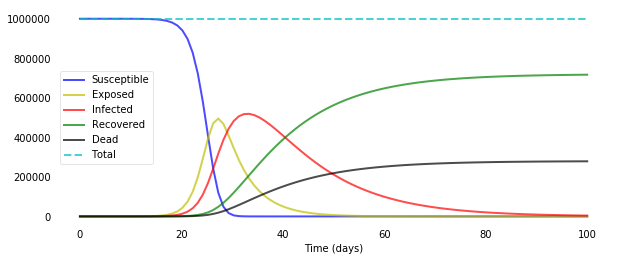

In [17]:
plotseird(t, S, E, I, R, D)